In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted.


In [ ]:
!nvidia-smi

Sun Nov 23 05:15:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Cell 2 — Install libraries
!pip install -q kaggle
!pip install -q pycocotools
!pip install -q segmentation-models-pytorch==0.3.0
!pip install -q albumentations==1.4.0
!pip install -q torchmetrics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.0/377.0 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 22.5 MB/s eta 0:00:00


In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [ ]:
!wget -nc http://images.cocodataset.org/zips/train2017.zip
!wget -nc http://images.cocodataset.org/zips/val2017.zip
!wget -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip


!unzip -qo train2017.zip
!unzip -qo val2017.zip
!unzip -qo annotations_trainval2017.zip

--2025-11-23 05:19:52--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 16.15.179.252, 52.217.92.20, 16.15.192.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|16.15.179.252|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G  57.1MB/s    in 5m 22s  

2025-11-23 05:25:14 (57.3 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]

--2025-11-23 05:25:14--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.25.166, 52.217.46.132, 52.217.86.100, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.25.166|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  

In [ ]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from pycocotools.coco import COCO
import segmentation_models_pytorch as smp

from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex

from tqdm import tqdm





In [ ]:
class COCODataset(Dataset):

    def __init__(self, img_dir, ann_file, transforms=None, max_images=None):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.transforms = transforms

        self.img_ids = self.coco.getImgIds()
        if max_images:
            self.img_ids = self.img_ids[:max_images]

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, info["file_name"])

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((info['height'], info['width']), dtype=np.uint8)

        for ann in anns:
            mask = np.logical_or(mask, self.coco.annToMask(ann))

        mask = (mask * 255).astype("uint8")

        if self.transforms:
            aug = self.transforms(image=image, mask=mask)
            image = aug["image"]
            mask = aug["mask"]

        return image, mask.unsqueeze(0)


In [ ]:
IMG_SIZE = 256
MAX_IMAGES = 40000    # You can lower to 2000 for faster training

train_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_tf = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

train_dataset = COCODataset(
    "/content/train2017",
    "/content/annotations/instances_train2017.json",
    transforms=train_tf,
    max_images=MAX_IMAGES
)

# 90% train / 10% validation
val_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_set, val_set = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=8, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, num_workers=4)

len(train_set), len(val_set)


loading annotations into memory...
Done (t=15.99s)
creating index...
index created!


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


(36000, 4000)

In [ ]:
# Cell 9 — Create model with pretrained encoder + extra layers

device = "cuda" if torch.cuda.is_available() else "cpu"

base_model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
)

# Freeze encoder
for param in base_model.encoder.parameters():
    param.requires_grad = False

# Extra layers (requested in your task)
extra_layers = nn.Sequential(
    nn.Conv2d(1, 1, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(1, 1, kernel_size=1)
)

class FinalModel(nn.Module):
    def __init__(self, base, extra):
        super().__init__()
        self.base = base
        self.extra = extra

    def forward(self, x):
        out = self.base(x)
        out = self.extra(out)
        return out

model = FinalModel(base_model, extra_layers).to(device)

print("Model created successfully!")


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 175MB/s]


Model created successfully!


In [ ]:


criterion_bce = nn.BCEWithLogitsLoss()

def dice_loss(pred, target, smooth=1.0):
    pred = torch.sigmoid(pred)
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - ((2. * intersection + smooth) / (pred.sum() + target.sum() + smooth))

def combined_loss(pred, target):
    return criterion_bce(pred, target) + dice_loss(pred, target)

LEARNING_RATE = 1e-3
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# NEW torchmetrics imports
from torchmetrics.classification import BinaryF1Score, BinaryJaccardIndex

# Dice ≈ F1 score for binary segmentation
dice_metric = BinaryF1Score().to(device)

# IoU (Jaccard Index)
iou_metric = BinaryJaccardIndex().to(device)



In [ ]:
def train_one_epoch():
    model.train()
    total = 0
    for img, mask in tqdm(train_loader):

        img = img.to(device).float()

        # Convert mask from uint8 -> float32 AND normalize (0 or 1)
        mask = mask.to(device).float() / 255.0

        optimizer.zero_grad()
        pred = model(img)

        loss = combined_loss(pred, mask)
        loss.backward()
        optimizer.step()

        total += loss.item()

    return total / len(train_loader)


def validate():
    model.eval()
    total = 0
    with torch.no_grad():
        for img, mask in tqdm(val_loader):

            img = img.to(device).float()
            mask = mask.to(device).float() / 255.0

            pred = model(img)
            loss = combined_loss(pred, mask)

            total += loss.item()

    return total / len(val_loader)



In [ ]:
EPOCHS = 3

for e in range(EPOCHS):
    train_l = train_one_epoch()
    val_l = validate()
    print(f"Epoch {e+1}/{EPOCHS} | Train Loss = {train_l:.4f} | Val Loss = {val_l:.4f}")

torch.save(model.state_dict(), "stage1.pth")


100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


Epoch 1/3 | Train Loss = 0.6651 | Val Loss = 0.5456


100%|██████████| 500/500 [00:48<00:00, 10.27it/s]


Epoch 2/3 | Train Loss = 0.5638 | Val Loss = 0.5145


100%|██████████| 500/500 [00:48<00:00, 10.23it/s]


Epoch 3/3 | Train Loss = 0.5340 | Val Loss = 0.5012


In [ ]:

for name, param in model.base.encoder.named_parameters():
    if "layer3" in name or "layer4" in name:   # unfreeze last 2 blocks
        param.requires_grad = True
        print(f"Unfreezing: {name}")
    else:
        param.requires_grad = False


optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-4
)

print("Fine-tuning setup complete.")


Unfreezing: layer3.0.conv1.weight
Unfreezing: layer3.0.bn1.weight
Unfreezing: layer3.0.bn1.bias
Unfreezing: layer3.0.conv2.weight
Unfreezing: layer3.0.bn2.weight
Unfreezing: layer3.0.bn2.bias
Unfreezing: layer3.0.downsample.0.weight
Unfreezing: layer3.0.downsample.1.weight
Unfreezing: layer3.0.downsample.1.bias
Unfreezing: layer3.1.conv1.weight
Unfreezing: layer3.1.bn1.weight
Unfreezing: layer3.1.bn1.bias
Unfreezing: layer3.1.conv2.weight
Unfreezing: layer3.1.bn2.weight
Unfreezing: layer3.1.bn2.bias
Unfreezing: layer3.2.conv1.weight
Unfreezing: layer3.2.bn1.weight
Unfreezing: layer3.2.bn1.bias
Unfreezing: layer3.2.conv2.weight
Unfreezing: layer3.2.bn2.weight
Unfreezing: layer3.2.bn2.bias
Unfreezing: layer3.3.conv1.weight
Unfreezing: layer3.3.bn1.weight
Unfreezing: layer3.3.bn1.bias
Unfreezing: layer3.3.conv2.weight
Unfreezing: layer3.3.bn2.weight
Unfreezing: layer3.3.bn2.bias
Unfreezing: layer3.4.conv1.weight
Unfreezing: layer3.4.bn1.weight
Unfreezing: layer3.4.bn1.bias
Unfreezing: lay

In [ ]:
#  CELL 14 — Fine-tuning WITH automatic checkpoint saving

EPOCHS_FINE = 5

for e in range(EPOCHS_FINE):

    print(f"\n----- Fine-tuning Epoch {e+1}/{EPOCHS_FINE} -----")

    t = train_one_epoch()
    v = validate()

    # Save checkpoint after each epoch
    checkpoint_path = f"/content/drive/MyDrive/fine_epoch_{e+1}.pth"
    torch.save(model.state_dict(), checkpoint_path)
    print(f"Checkpoint saved: fine_epoch_{e+1}.pth")

    print(f"Fine {e+1}/{EPOCHS_FINE} | Train {t:.4f} | Val {v:.4f}")




----- Fine-tuning Epoch 1/5 -----


100%|██████████| 500/500 [00:48<00:00, 10.37it/s]


Checkpoint saved: fine_epoch_1.pth
Fine 1/5 | Train 0.5489 | Val 0.5112

----- Fine-tuning Epoch 2/5 -----


100%|██████████| 500/500 [00:49<00:00, 10.09it/s]


Checkpoint saved: fine_epoch_2.pth
Fine 2/5 | Train 0.5110 | Val 0.5056

----- Fine-tuning Epoch 3/5 -----


100%|██████████| 500/500 [00:50<00:00,  9.94it/s]


Checkpoint saved: fine_epoch_3.pth
Fine 3/5 | Train 0.4828 | Val 0.4958

----- Fine-tuning Epoch 4/5 -----


100%|██████████| 500/500 [00:48<00:00, 10.27it/s]


Checkpoint saved: fine_epoch_4.pth
Fine 4/5 | Train 0.4562 | Val 0.4959

----- Fine-tuning Epoch 5/5 -----


100%|██████████| 500/500 [00:48<00:00, 10.32it/s]


Checkpoint saved: fine_epoch_5.pth
Fine 5/5 | Train 0.4291 | Val 0.4839


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/final_segmentation_model.pth")
print("Model Saved Successfully!")


Model Saved Successfully!


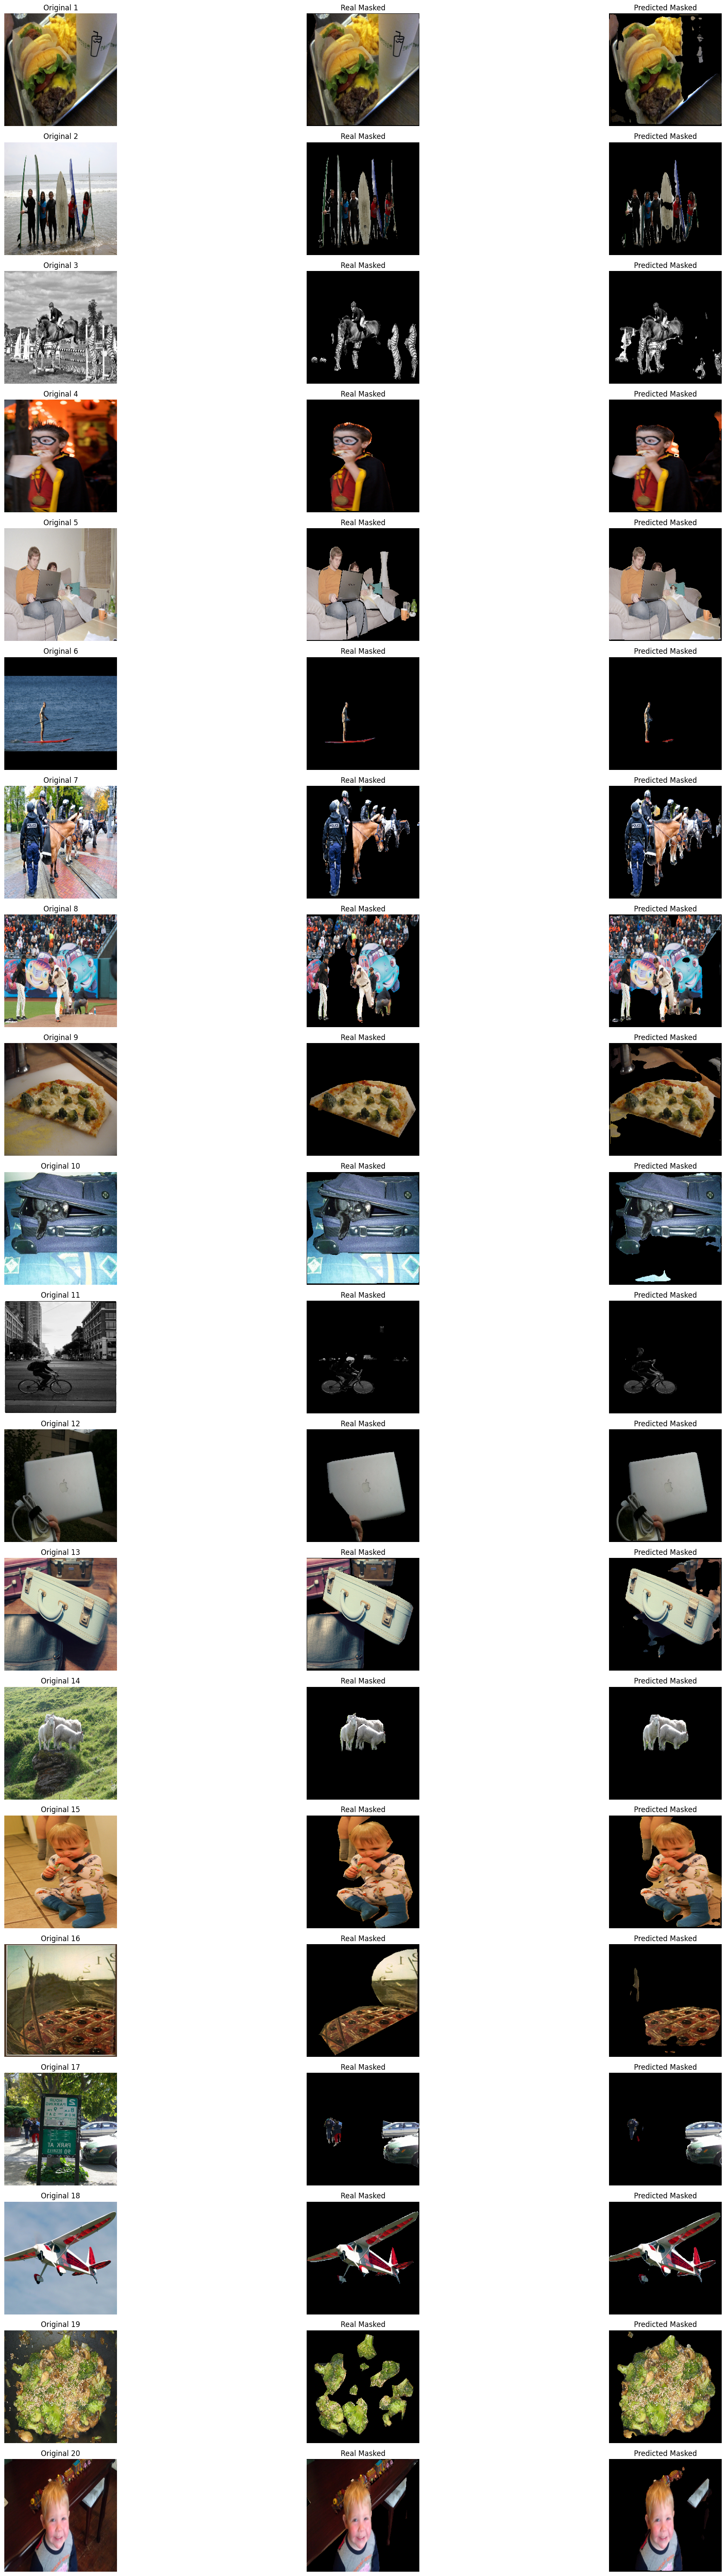

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def denormalize(x):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    return (x * std) + mean

num_samples = 20
rows, cols = 20, 3

plt.figure(figsize=(25, 60))

model.eval()

for i in range(num_samples):

    idx = random.randint(0, len(val_set)-1)
    img, true_mask = val_set[idx]

    img_np = denormalize(img.permute(1,2,0).cpu().numpy())
    img_np = np.clip(img_np, 0, 1)

    true_mask_np = true_mask.squeeze().cpu().numpy().astype(np.uint8)

    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
        pred_mask = (torch.sigmoid(pred).cpu().squeeze().numpy() > 0.5).astype(np.uint8)

    real_masked = img_np.copy()
    real_masked[true_mask_np == 0] = 0

    pred_masked = img_np.copy()
    pred_masked[pred_mask == 0] = 0

    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(img_np)
    plt.title(f"Original {i+1}")
    plt.axis("off")

    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(real_masked)
    plt.title("Real Masked")
    plt.axis("off")

    plt.subplot(rows, cols, i*cols + 3)
    plt.imshow(pred_masked)
    plt.title("Predicted Masked")
    plt.axis("off")

plt.tight_layout()
plt.show()






In [ ]:
from tqdm import tqdm

model.eval()

dice_metric = BinaryF1Score().to(device)
iou_metric  = BinaryJaccardIndex().to(device)

dice_scores = []
iou_scores = []

with torch.no_grad():
    for img, mask in tqdm(val_loader):

        img = img.to(device).float()
        mask = (mask.to(device).float() / 255.0)

        pred = torch.sigmoid(model(img))
        pred = (pred > 0.5).float()

        dice = dice_metric(pred, mask).cpu().item()
        iou  = iou_metric(pred, mask).cpu().item()

        dice_scores.append(dice)
        iou_scores.append(iou)

print("=============================================")
print(f"Dice Score (Accuracy)      : {np.mean(dice_scores):.4f}")
print(f"IoU Score (Intersection)   : {np.mean(iou_scores):.4f}")
print("=============================================")


100%|██████████| 500/500 [00:47<00:00, 10.59it/s]

Dice Score (Accuracy)      : 0.8186
IoU Score (Intersection)   : 0.6989


In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/final_segmentation_model.pth"))
model.to(device)
model.eval()

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
from google.colab import files
files.upload()

!unzip -qo pictures.zip -d /content/test_images


Saving pictures.zip to pictures.zip


In [ ]:
import glob
import os

# Path where your downloaded images are stored
test_dir = "/content/test_images"

# Extensions allowed
extensions = ['*.jpg', '*.jpeg', '*.png', '*.webp']

image_paths = []
for ext in extensions:
    image_paths.extend(glob.glob(os.path.join(test_dir, '**', ext), recursive=True))

# Display how many valid images found
print("Total valid images found:", len(image_paths))

# Print first few paths to confirm
image_paths[:10]




Total valid images found: 14


['/content/test_images/pictures/girlss.jpg',
 '/content/test_images/pictures/taj.jpg',
 '/content/test_images/pictures/boat.jpg',
 '/content/test_images/pictures/dog.jpg',
 '/content/test_images/pictures/berry.jpg',
 '/content/test_images/pictures/elephant.jpg',
 '/content/test_images/r.jpeg',
 '/content/test_images/pictures/teddy.jpeg',
 '/content/test_images/pictures/food.jpeg',
 '/content/test_images/pictures/girl.jpeg']

Found 14 images for testing


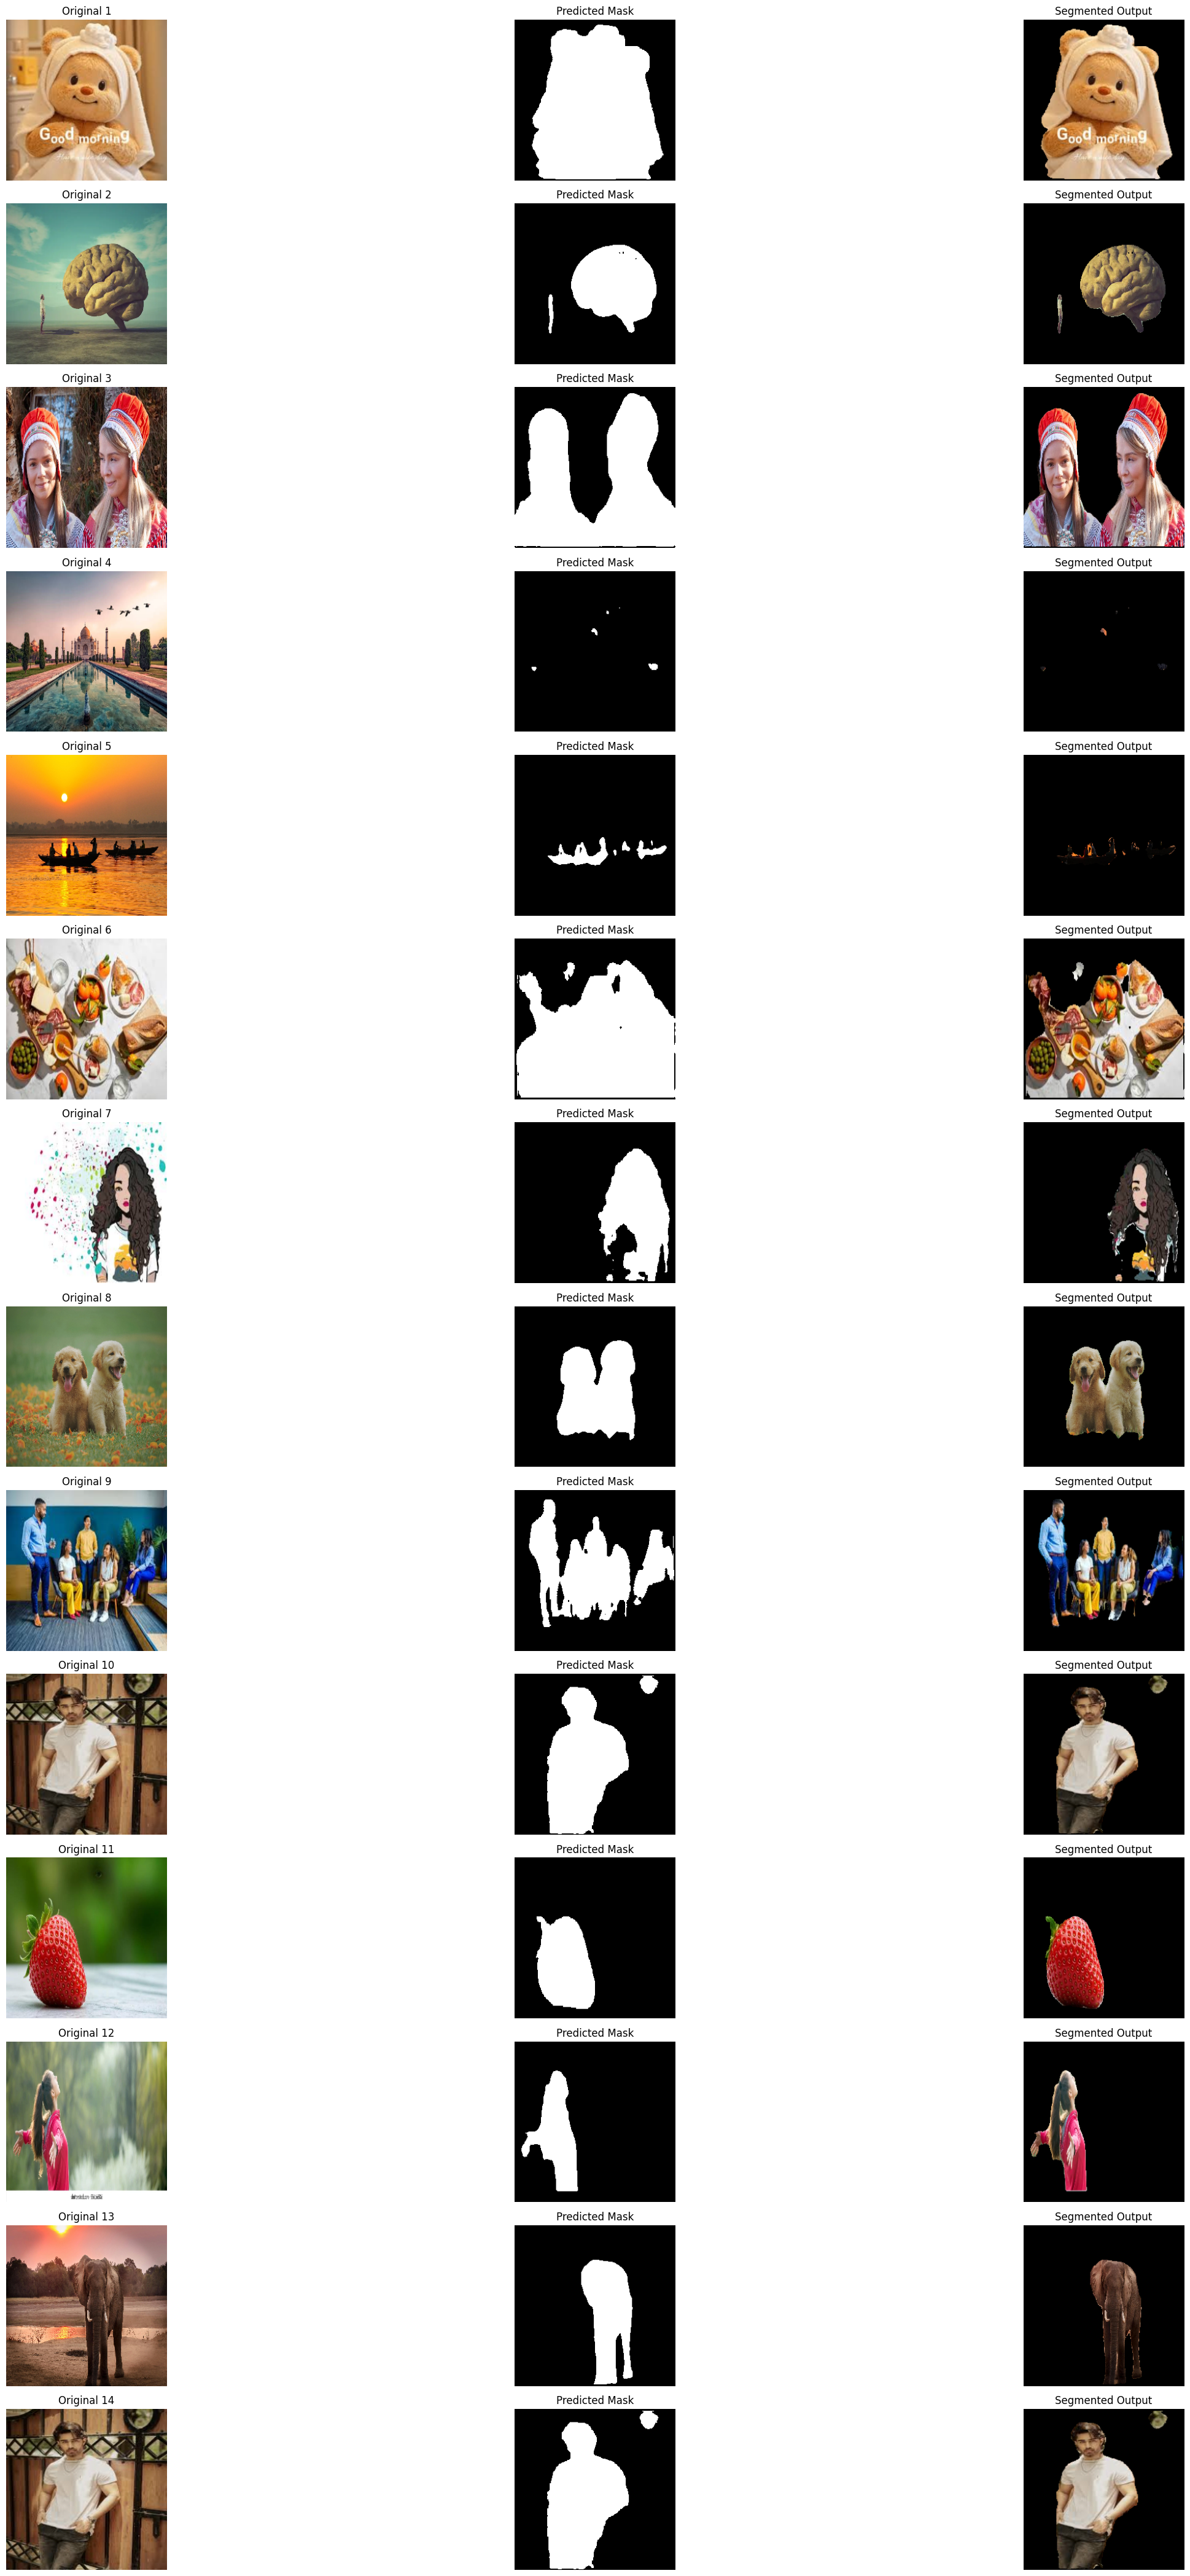

In [ ]:
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

model.eval()

image_paths = glob.glob("/content/test_images/*/*") + glob.glob("/content/test_images/*")
image_paths = [p for p in image_paths if p.lower().endswith((".jpg", ".jpeg", ".png", ".webp"))]

print(f"Found {len(image_paths)} images for testing")

rows, cols = 20, 3
plt.figure(figsize=(25, 60))

def preprocess_image(img):
    img_resized = cv2.resize(img, (256, 256))
    img_norm = img_resized / 255.0
    img_norm = (img_norm - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
    img_norm = np.transpose(img_norm, (2, 0, 1))
    return torch.tensor(img_norm).unsqueeze(0).float().to(device)

for i, path in enumerate(image_paths[:20]):

    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Prepare input
    inp = preprocess_image(img_rgb)

    with torch.no_grad():
        pred = model(inp)
        pred_mask = (torch.sigmoid(pred).cpu().squeeze().numpy() > 0.5).astype(np.uint8)

    # ---- Resize mask to original image size (for correct masking) ----
    pred_mask_resized = cv2.resize(pred_mask,
                                   (img_rgb.shape[1], img_rgb.shape[0]),
                                   interpolation=cv2.INTER_NEAREST)

    # ---- Apply mask ----
    masked = img_rgb.copy()
    masked[pred_mask_resized == 0] = 0

    # ---- Make all images SAME DISPLAY SIZE (256×256) ----
    img_disp = cv2.resize(img_rgb, (256, 256))
    mask_disp = cv2.resize(pred_mask_resized, (256, 256))
    masked_disp = cv2.resize(masked, (256, 256))

    # ---- Plot ----
    plt.subplot(rows, cols, i*cols + 1)
    plt.imshow(img_disp)
    plt.title(f"Original {i+1}")
    plt.axis("off")

    plt.subplot(rows, cols, i*cols + 2)
    plt.imshow(mask_disp, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.subplot(rows, cols, i*cols + 3)
    plt.imshow(masked_disp)
    plt.title("Segmented Output")
    plt.axis("off")

plt.tight_layout()
plt.show()
